In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

In [3]:
db_file = 'sensor_daten.sqlite'
conn = sqlite3.connect(db_file)

query = "SELECT * FROM WeatherData"

df_start = pd.read_sql_query(query, conn)

conn.close()
df_start.head(3)

,createdAt,Temperatur,rel_Luftfeuchte,Luftdruck,Bodenfeuchte,Bodentemperatur,Licht,UV_Index,PM25,PM10,station
0,2022-09-28T00:00:40.694Z,7.96,99.99,998.76,26.00,17.68,0.0,0.0,6.6,1.4,WetterBrg
1,2022-09-28T00:01:40.707Z,7.95,99.99,998.82,26.10,10.26,0.0,0.0,3.1,1.3,WetterBrg
2,2022-09-28T00:02:40.751Z,7.95,99.99,998.82,25.78,10.59,0.0,0.0,3.4,1.3,WetterBrg


In [4]:
df_start.station.value_counts()
df_start = df_start[df_start['station'] == 'PoS']
df_start_new = df_start.drop(columns=['station', 'UV_Index'])

# Eliminate outliers by hand which we know for certain are incorrect
thresholds = {
    'Temperatur': (-50, 60), # Grenzwerte gewählt, da es  Messungen bis 950°C gab
    'Luftdruck': (950, 1060), # ungefähr die minimale und maximale jemals in DE gemessenen Werte
    'Bodenfeuchte': (0, 150), # Bodenfeuchte in %, bei starkem Regen können die Werte kurzfristig über 100% steigen
    'Bodentemperatur': (-50, 60), # es gab zum Teil Messungen von 360 Tsd.°C
}

filtered_df = df_start_new.apply(lambda col: col.where((col >= thresholds[col.name][0]) & (col <= thresholds[col.name][1]), np.nan) 
              if col.name in thresholds else col)


df_start_new['createdAt'] = pd.to_datetime(df_start_new['createdAt'], format=('%Y-%m-%dT%H:%M:%S.%fZ')).dt.floor('s')
df_start_new['createdAt'] = pd.to_datetime(df_start_new['createdAt'])
df_start_new['createdAt'] = df_start_new['createdAt'].dt.floor('h')
df_hourly = df_start_new.groupby('createdAt').mean().reset_index()
df_hourly = df_hourly.round(3)
df_hourly.head(3)

def clamp_row(row):
    if row.name in ["createdAt"]:
        return row  # Return the row unchanged if it's in the excluded list
    lower_percentile = row.quantile(0.05)
    upper_percentile = row.quantile(0.95)
    return row.clip(lower=lower_percentile, upper=upper_percentile)

df_hourly = df_hourly.apply(clamp_row, axis=0)
df_hourly_tail = df_hourly.tail(672) # 3 Wochen
df_hourly_tail

,createdAt,Temperatur,rel_Luftfeuchte,Luftdruck,Bodenfeuchte,Bodentemperatur,Licht,PM25,PM10
14213,2024-05-30 00:00:00,14.181,99.990,975.133,10.916,16.472,0.000,0.942,1.945
14214,2024-05-30 01:00:00,13.988,99.990,974.501,10.892,14.351,0.000,0.978,2.153
14215,2024-05-30 02:00:00,13.771,99.990,973.708,10.884,14.544,0.083,1.040,2.167
14216,2024-05-30 03:00:00,13.710,99.990,973.213,10.583,13.534,6.000,1.108,2.050
14217,2024-05-30 04:00:00,13.974,99.990,972.606,10.542,14.142,45.850,1.083,2.267
...,...,...,...,...,...,...,...,...,...
14880,2024-06-26 19:00:00,22.737,84.379,976.325,12.116,22.075,4.167,3.153,7.520
14881,2024-06-26 20:00:00,22.126,88.358,976.301,11.902,21.242,0.000,3.303,7.738
14882,2024-06-26 21:00:00,21.287,92.004,976.318,11.773,20.971,0.000,3.672,8.534
14883,2024-06-26 22:00:00,20.399,95.427,976.176,11.694,20.447,0.000,4.093,9.343


In [5]:
predictions = {}
steps = 24

df = df_hourly_tail.drop(columns="createdAt")

for column in tqdm(df.columns):
    # Unabhängige Variable (Zielvariable)
    y = df[column]
    
    # SARIMAX-Modell fitten (ohne exogene Variablen)
    model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()
    
    # Vorhersage für die nächsten 24 Perioden
    forecast = model.get_forecast(steps=24)
    forecast_values = forecast.predicted_mean
    
    # Speichern der Vorhersagewerte
    predictions[column] = forecast_values

# Erstellen eines DataFrames aus den Vorhersagen
predictions_df = pd.DataFrame(predictions)

100%|██████████| 8/8 [00:31<00:00,  3.97s/it]


,Temperatur,rel_Luftfeuchte,Luftdruck,Bodenfeuchte,Bodentemperatur,Licht,PM25,PM10
14885,18.972109,101.221293,976.539385,11.492522,19.228474,28.004373,3.978679,9.137699
14886,18.444727,103.172054,976.505601,11.494640,19.166411,48.284418,3.908664,9.156656
14887,17.947723,104.095547,976.538486,11.354422,18.560910,63.539245,3.906055,9.245822
14888,17.591162,104.964046,976.604824,11.404736,18.779456,104.931624,3.897114,9.364489
14889,17.889796,105.661836,976.796003,11.383013,18.572438,212.645680,3.948050,9.508278
14890,19.168339,102.091671,977.034799,11.437351,18.988124,336.307241,3.934297,9.397874
14891,21.273846,93.286378,977.148140,11.569211,19.833613,459.601811,3.932063,9.403178
14892,25.009925,80.681264,977.215953,11.684688,20.679536,988.557165,3.844103,9.073485
14893,27.184697,71.967475,977.236615,11.963580,22.134567,2365.013211,3.866915,8.964388
14894,28.234389,66.767922,977.179977,12.290359,24.006893,2951.214527,3.960200,9.023654


C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_18236\4073065001.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  seq_datetime = pd.date_range(start=combined_df.loc[~nan_indices, 'createdAt'].iloc[0],


<Figure size 640x480 with 0 Axes>

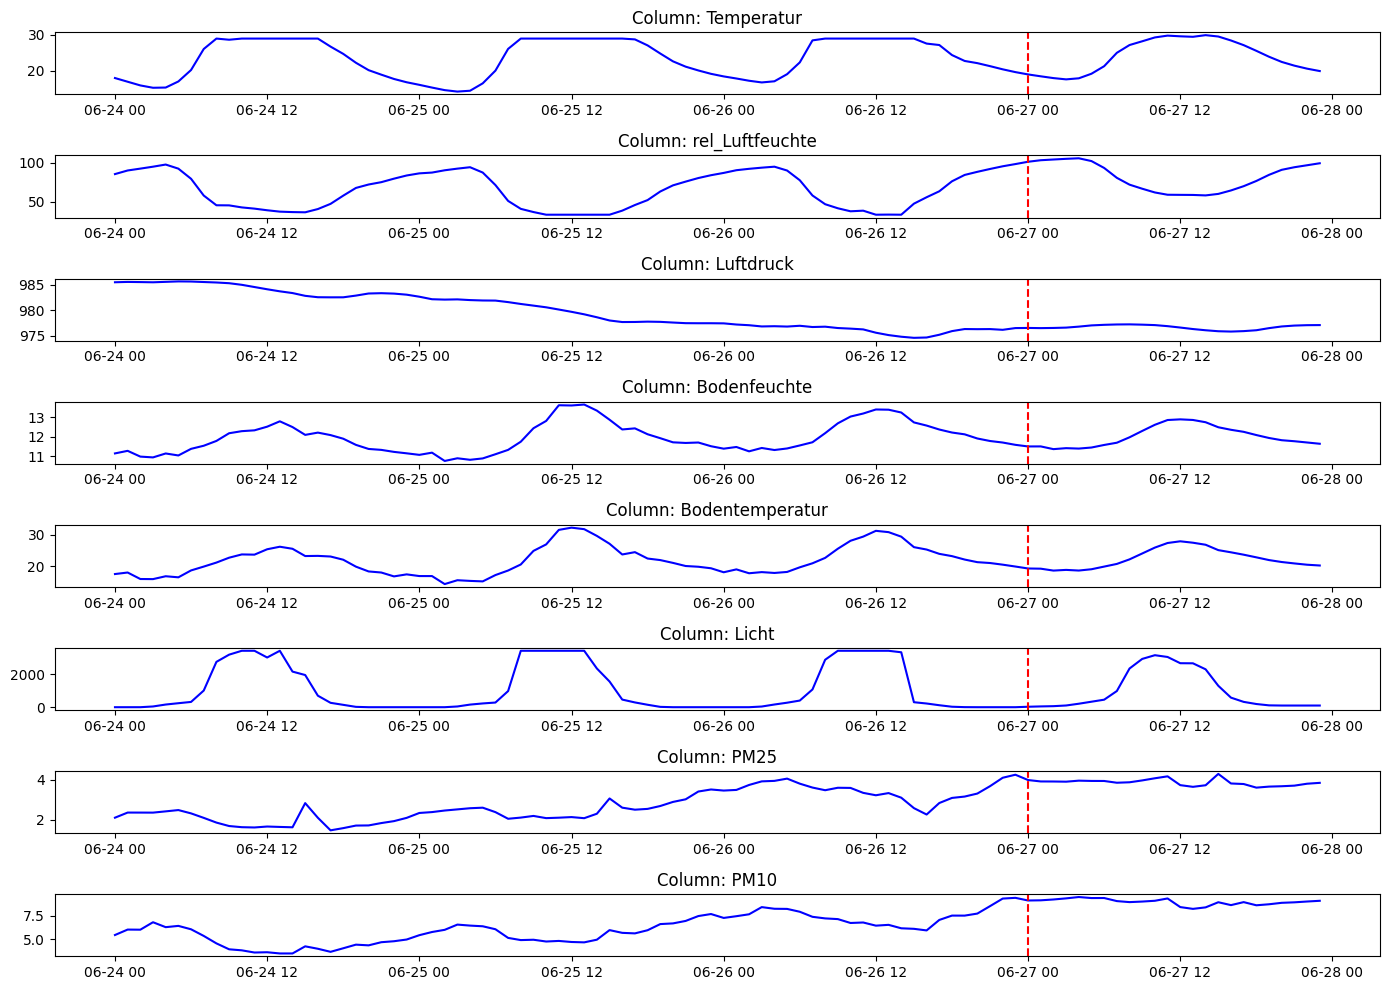

In [6]:
plt.figure()
tail = 72

df_tail = df_hourly.tail(72)
plt.figure(figsize=(14, 10))
combined_df = pd.concat([df_tail, predictions_df]).reset_index(drop=True)

nan_indices = combined_df['createdAt'].isna()
seq_datetime = pd.date_range(start=combined_df.loc[~nan_indices, 'createdAt'].iloc[0],
                             periods=len(combined_df),
                             freq='H')

# Fill NaN values in 'createdAt' with sequentially increasing datetime values
combined_df.loc[nan_indices, 'createdAt'] = seq_datetime[nan_indices]
combined_df.to_parquet("./predictions.parquet")

for i, column in enumerate(predictions_df.columns):
    plt.subplot(len(predictions_df.columns), 1, i + 1)
    plt.plot(combined_df.createdAt, combined_df[column], label='Original', color='blue')

    last_index = combined_df.iloc[-24].createdAt
    plt.axvline(x=last_index, color='red', linestyle='--', label='Last 24 Values')

    plt.title(f'Column: {column}')

plt.tight_layout()
plt.show()